# Transformer

<div style="display: flex; align-items: center;">
    <img src="../imgs/Transformer.jpg" alt="Your Image" width="300" style="margin-right: 20px;">
    <div>
        <p>The Transformer model is a revolutionary deep learning architecture that, with its unique self attention mechanism as its core, completely changes the way sequence modeling is done. This mechanism allows the model to consider all elements in parallel when processing sequences, rather than gradually processing them in order like traditional recurrent neural networks, greatly improving computational efficiency. Through multi head attention, Transformer can simultaneously capture sequence information from different perspectives, enhancing the model's ability to learn complex features.</p>
        <p>In addition to self attention mechanism, Transformer also introduces positional encoding to solve the problem of element order in sequences, which is crucial for maintaining the temporal sensitivity of sequence data. In each encoder and decoder layer of the model, the output of the self attention layer is transmitted to the feedforward network for further feature extraction and processing. In order to improve the training stability of deep networks, Transformer adopts layer normalization technology and alleviates the problem of gradient vanishing through residual connections, making the training of deep networks more feasible.</p>
        <p>These design features of the Transformer model have quickly made it mainstream in the field of natural language processing, especially in tasks such as machine translation, text summarization, and question answering systems. Its flexibility and powerful representation ability have also shown wide application potential in other fields such as speech recognition and image processing, making it one of the most influential models in the current field of deep learning.</p>
    </div>
</div>

# Vision Transformer

<div style="display: flex; align-items: center;">
    <img src="../imgs/ViT.jpg" alt="Your Image" width="600" style="margin-right: 20px;">
    <div>
        <p>ViT (vision transformer) is a model proposed by Google in 2020 that directly applies transformer to image classification. Many subsequent works have been improved based on ViT. The idea of ViT is simple: directly divide the image into fixed size patches, and then obtain patch embeddings through linear transformation, which is similar to NLP's words and word embeddings. Since the input of the transformer is a sequence of token embeddings, the patch embeddings of the image can be fed into the transformer for feature extraction and classification. As shown in the schematic diagram of the ViT model, in fact, the ViT model only uses the Encoder of the transformer to extract features (the original transformer also has a decoder section, which is used to implement sequence to sequence, such as machine translation).</p>
        <p></p>
    </div>
</div>

## ViT

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Patch Embedding
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size * self.grid_size
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (B, embed_dim, N)
        x = x.transpose(1, 2)  # (B, N, embed_dim)
        return x

# Attention
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each shape: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

# Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False):
        super(EncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, qkv_bias)
        self.norm2 = nn.LayerNorm(dim)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, dim),
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Encoder
class Encoder(nn.Module):
    def __init__(self, depth, dim, num_heads, mlp_ratio=4., qkv_bias=False):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            EncoderBlock(dim, num_heads, mlp_ratio, qkv_bias) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        return x

# Vision Transformer (ViT)
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, 
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)
        
        self.encoder = Encoder(depth, embed_dim, num_heads, mlp_ratio, qkv_bias)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_layer_weights)

    def _init_layer_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + N, embed_dim)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        x = self.encoder(x)
        cls_token_final = x[:, 0]  # Extract the class token
        x = self.head(cls_token_final)
        return x

## Train ViT on CIFAR100

In [2]:
import sys
import torch.nn as nn
sys.path.append('../tools')
from CIFAR10 import CIFAR10Trainer
from CIFAR100 import CIFAR100Trainer

Vision Transformers (ViTs), while highly effective on large-scale datasets, may underperform compared to Convolutional Neural Networks (CNNs) on smaller or simpler datasets without pre-training due to several factors. ViTs require substantial data to leverage their large model capacity, which can lead to overfitting on limited data. Their design focuses on capturing global dependencies, which might be excessive for the local pattern recognition needed in smaller datasets. Additionally, without the feature-rich initialization provided by pre-training, ViTs struggle to learn from scratch, unlike CNNs that are inherently efficient and can quickly adapt to available data due to their architectural advantages in processing spatial hierarchies. So in this chapter, we will only introduce the concept and structure of ViT. For application scenarios, you can explore them yourself, and I will also try to demonstrate them in later chapters.

Files already downloaded and verified
Files already downloaded and verified
2024-05-22 18:18:33
Epoch 1 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:05<00:00,  7.08it/s, val_acc=14.1, val_loss=0.0292]


2024-05-22 18:19:29
Epoch 2 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.89it/s, val_acc=18.8, val_loss=0.0271]


2024-05-22 18:20:34
Epoch 3 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.74it/s, val_acc=21.7, val_loss=0.0257]


2024-05-22 18:21:48
Epoch 4 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:10<00:00,  3.81it/s, val_acc=24.4, val_loss=0.0245]


2024-05-22 18:23:09
Epoch 5 / 50


[Valid]: 100%|█████████████████████████| 40/40 [00:09<00:00,  4.20it/s, val_acc=27, val_loss=0.0236]


2024-05-22 18:24:31
Epoch 6 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.29it/s, val_acc=29.3, val_loss=0.0227]


2024-05-22 18:25:48
Epoch 7 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.44it/s, val_acc=29.5, val_loss=0.0228]


2024-05-22 18:27:08
Epoch 8 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.03it/s, val_acc=30.5, val_loss=0.0222]


2024-05-22 18:28:27
Epoch 9 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:11<00:00,  3.61it/s, val_acc=31.5, val_loss=0.0218]


2024-05-22 18:29:50
Epoch 10 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.07it/s, val_acc=30.5, val_loss=0.0224]


2024-05-22 18:31:14
Epoch 11 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.78it/s, val_acc=31.8, val_loss=0.0225]


2024-05-22 18:32:34
Epoch 12 / 50


[Valid]: 100%|████████████████████████| 40/40 [00:08<00:00,  4.46it/s, val_acc=31.3, val_loss=0.023]


2024-05-22 18:33:47
Epoch 13 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.54it/s, val_acc=32.1, val_loss=0.0233]


2024-05-22 18:35:04
Epoch 14 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.51it/s, val_acc=31.9, val_loss=0.0245]


2024-05-22 18:36:20
Epoch 15 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.76it/s, val_acc=31.7, val_loss=0.0254]


2024-05-22 18:37:36
Epoch 16 / 50


[Valid]: 100%|████████████████████████| 40/40 [00:13<00:00,  3.04it/s, val_acc=32.1, val_loss=0.026]


2024-05-22 18:39:09
Epoch 17 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:11<00:00,  3.37it/s, val_acc=31.7, val_loss=0.0278]


2024-05-22 18:40:46
Epoch 18 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:13<00:00,  2.90it/s, val_acc=31.8, val_loss=0.0287]


2024-05-22 18:42:27
Epoch 19 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:12<00:00,  3.18it/s, val_acc=33.2, val_loss=0.0293]


2024-05-22 18:44:08
Epoch 20 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:10<00:00,  3.89it/s, val_acc=32.8, val_loss=0.0309]


2024-05-22 18:45:34
Epoch 21 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.30it/s, val_acc=33.8, val_loss=0.0306]


2024-05-22 18:46:54
Epoch 22 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:10<00:00,  3.91it/s, val_acc=34.5, val_loss=0.0312]


2024-05-22 18:48:13
Epoch 23 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.04it/s, val_acc=35.5, val_loss=0.0311]


2024-05-22 18:49:32
Epoch 24 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.26it/s, val_acc=35.4, val_loss=0.0314]


2024-05-22 18:50:52
Epoch 25 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.39it/s, val_acc=35.9, val_loss=0.0311]


2024-05-22 18:52:10
Epoch 26 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:10<00:00,  3.83it/s, val_acc=36.3, val_loss=0.0316]


2024-05-22 18:53:31
Epoch 27 / 50


[Valid]: 100%|█████████████████████████| 40/40 [00:11<00:00,  3.61it/s, val_acc=36, val_loss=0.0316]


2024-05-22 18:55:04
Epoch 28 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:10<00:00,  3.72it/s, val_acc=36.4, val_loss=0.0316]


2024-05-22 18:56:35
Epoch 29 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:11<00:00,  3.63it/s, val_acc=36.4, val_loss=0.0319]


2024-05-22 18:58:08
Epoch 30 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:11<00:00,  3.42it/s, val_acc=36.5, val_loss=0.0318]


2024-05-22 18:59:36
Epoch 31 / 50


[Valid]: 100%|████████████████████████| 40/40 [00:11<00:00,  3.49it/s, val_acc=36.9, val_loss=0.032]


2024-05-22 19:01:11
Epoch 32 / 50


[Valid]: 100%|████████████████████████| 40/40 [00:11<00:00,  3.60it/s, val_acc=36.6, val_loss=0.032]


2024-05-22 19:02:40
Epoch 33 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:10<00:00,  3.92it/s, val_acc=36.7, val_loss=0.0322]


2024-05-22 19:04:04
Epoch 34 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.06it/s, val_acc=36.8, val_loss=0.0323]


2024-05-22 19:05:25
Epoch 35 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:12<00:00,  3.25it/s, val_acc=37.1, val_loss=0.0324]


2024-05-22 19:07:02
Epoch 36 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:10<00:00,  3.92it/s, val_acc=36.9, val_loss=0.0324]


2024-05-22 19:08:36
Epoch 37 / 50


[Valid]: 100%|█████████████████████████| 40/40 [00:09<00:00,  4.24it/s, val_acc=37, val_loss=0.0324]


2024-05-22 19:09:55
Epoch 38 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.02it/s, val_acc=37.2, val_loss=0.0325]


2024-05-22 19:11:13
Epoch 39 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.32it/s, val_acc=36.8, val_loss=0.0325]


2024-05-22 19:12:32
Epoch 40 / 50


[Valid]: 100%|█████████████████████████| 40/40 [00:09<00:00,  4.11it/s, val_acc=37, val_loss=0.0326]


2024-05-22 19:13:53
Epoch 41 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.07it/s, val_acc=37.1, val_loss=0.0326]


2024-05-22 19:15:13
Epoch 42 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.30it/s, val_acc=37.2, val_loss=0.0327]


2024-05-22 19:16:34
Epoch 43 / 50


[Valid]: 100%|█████████████████████████| 40/40 [00:10<00:00,  3.99it/s, val_acc=37, val_loss=0.0327]


2024-05-22 19:17:58
Epoch 44 / 50


[Valid]: 100%|█████████████████████████| 40/40 [00:09<00:00,  4.14it/s, val_acc=37, val_loss=0.0328]


2024-05-22 19:19:17
Epoch 45 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:08<00:00,  4.66it/s, val_acc=36.9, val_loss=0.0328]


2024-05-22 19:20:36
Epoch 46 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.31it/s, val_acc=37.1, val_loss=0.0329]


2024-05-22 19:21:55
Epoch 47 / 50


[Valid]: 100%|████████████████████████| 40/40 [00:09<00:00,  4.31it/s, val_acc=37.2, val_loss=0.033]


2024-05-22 19:23:13
Epoch 48 / 50


[Valid]: 100%|███████████████████████| 40/40 [00:09<00:00,  4.27it/s, val_acc=36.9, val_loss=0.0331]


2024-05-22 19:24:28
Epoch 49 / 50


[Valid]: 100%|██████████████████████████| 40/40 [00:09<00:00,  4.21it/s, val_acc=37, val_loss=0.033]


2024-05-22 19:25:45
Epoch 50 / 50


[Valid]: 100%|████████████████████████| 40/40 [00:09<00:00,  4.08it/s, val_acc=37.2, val_loss=0.033]


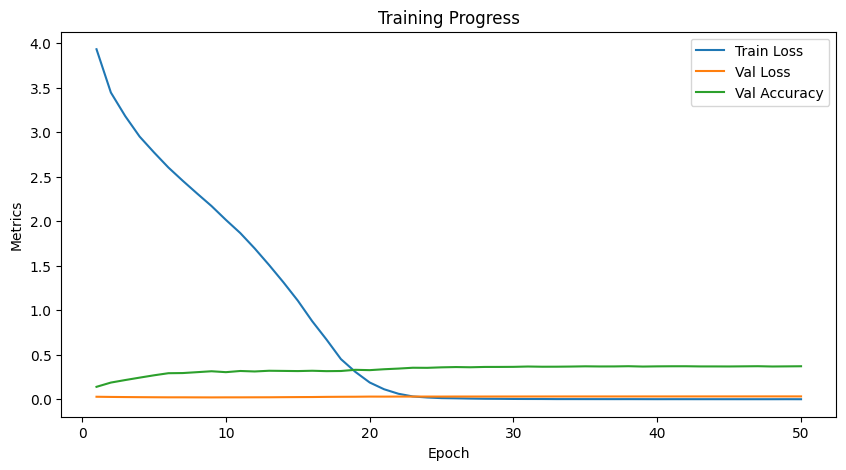

Testing [Test]: 100%|██████████████████████████████████| 79/79 [00:17<00:00,  4.52it/s, test_acc=36.9, test_loss=0.032]


In [4]:
model = VisionTransformer(img_size=32, patch_size=4, in_chans=3, num_heads=3, depth=3, embed_dim=768, mlp_ratio=2, num_classes=100)
trainer = CIFAR100Trainer(model, loss='CE', lr=0.01, optimizer='SGD', batch_size=128, epoch=50, model_type='classification')
trainer.train()
trainer.test()